In [1]:
# following codes were tested with Anaconda environment online.

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

In [2]:
from time import process_time

In [3]:
import tensorflow as tf
# GPU was recognized by installing cudatoolkit :
# conda install cudatoolkit=10.1

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2533613847776053544
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8975589805138168855
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 980006328469907305
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16304987780485373078
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10562779264
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15257683738315873864
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10260735616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 162

In [6]:
# tf.test.gpu_device_name()
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [7]:
from platform import python_version

print(python_version())

3.7.9


In [8]:
keras.__version__

'2.4.0'

In [9]:
tf.__version__

'2.3.0'

In [10]:
img_height=400
img_width=518
batch_size=32

In [11]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    '../data',labels='inferred',label_mode='int',
    validation_split=0.2, subset='training',
    seed=123,color_mode='grayscale',
    image_size=(img_height,img_width),
    batch_size=batch_size
    )

Found 280 files belonging to 2 classes.
Using 224 files for training.


In [12]:
val_ds=tf.keras.preprocessing.image_dataset_from_directory(
    '../data',labels='inferred',label_mode='int',
    validation_split=0.2, subset='validation',
    seed=123,color_mode='grayscale',
    image_size=(img_height,img_width),
    batch_size=batch_size
    )

Found 280 files belonging to 2 classes.
Using 56 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['par1', 'wt']


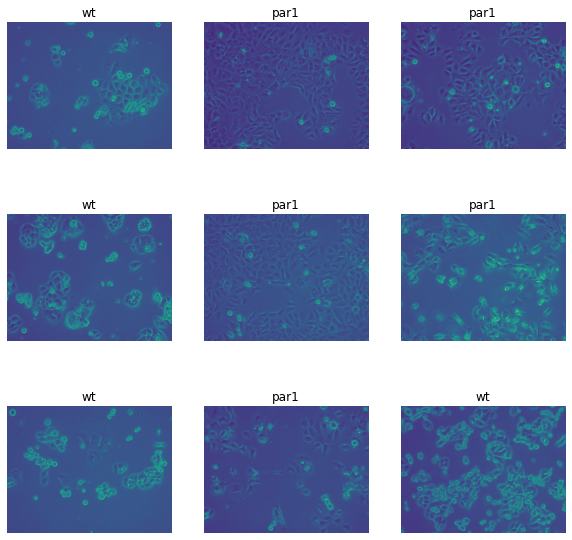

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

for images,labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [15]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 400, 518, 1)
(32,)


In [16]:
# Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. 
# These are two important methods you should use when loading data.

# Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. 
# This will ensure the dataset does not become a bottleneck while training your model. 
# If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk 
# cache.

# Dataset.prefetch() overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
# This is for normalization foorr RBG channel. We used Grayscale, so search whether this is required 
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [18]:
num_classes = 2

In [22]:
# Create the model (Note that below model does not contain drop out)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'), #original 128
#   layers.Dense(512, activation='softmax'), #original 128
  layers.Dense(num_classes)
])

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 400, 518, 1)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 400, 518, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 200, 259, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 200, 259, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 100, 129, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 100, 129, 128)     73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 64, 128)      

In [25]:
# on CPU only : 32 min.
# using GPU : 1 min 18s

t0_start=process_time()

epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
t0_stop=process_time()
print("Elapsed time: ", t0_stop, t0_start)
print("Time for total "+str(epochs) +" epochs : "+str((t0_stop-t0_start)/600) +" min.")

Epoch 1/100
7/7 [==============================] - 5s 757ms/step - loss: 4.8522 - accuracy: 0.4866 - val_loss: 0.7136 - val_accuracy: 0.3571
Epoch 2/100
7/7 [==============================] - 1s 100ms/step - loss: 0.6897 - accuracy: 0.5268 - val_loss: 0.6783 - val_accuracy: 0.6429
Epoch 3/100
7/7 [==============================] - 1s 96ms/step - loss: 0.6710 - accuracy: 0.5804 - val_loss: 0.6694 - val_accuracy: 0.6786
Epoch 4/100
7/7 [==============================] - 1s 96ms/step - loss: 0.6071 - accuracy: 0.6786 - val_loss: 0.7320 - val_accuracy: 0.3750
Epoch 5/100
7/7 [==============================] - 1s 96ms/step - loss: 0.5617 - accuracy: 0.6205 - val_loss: 0.5873 - val_accuracy: 0.6786
Epoch 6/100
7/7 [==============================] - 1s 96ms/step - loss: 0.4949 - accuracy: 0.7277 - val_loss: 0.5956 - val_accuracy: 0.6786
Epoch 7/100
7/7 [==============================] - 1s 96ms/step - loss: 0.3708 - accuracy: 0.8661 - val_loss: 0.8842 - val_accuracy: 0.3929
Epoch 8/100
7/7 [=

7/7 [==============================] - 1s 98ms/step - loss: 8.8405e-06 - accuracy: 1.0000 - val_loss: 1.5534 - val_accuracy: 0.7321
Epoch 57/100
7/7 [==============================] - 1s 98ms/step - loss: 8.2742e-06 - accuracy: 1.0000 - val_loss: 1.5526 - val_accuracy: 0.7321
Epoch 58/100
7/7 [==============================] - 1s 97ms/step - loss: 7.8128e-06 - accuracy: 1.0000 - val_loss: 1.5574 - val_accuracy: 0.7321
Epoch 59/100
7/7 [==============================] - 1s 98ms/step - loss: 7.4015e-06 - accuracy: 1.0000 - val_loss: 1.5615 - val_accuracy: 0.7321
Epoch 60/100
7/7 [==============================] - 1s 98ms/step - loss: 7.0327e-06 - accuracy: 1.0000 - val_loss: 1.5587 - val_accuracy: 0.7321
Epoch 61/100
7/7 [==============================] - 1s 97ms/step - loss: 6.6522e-06 - accuracy: 1.0000 - val_loss: 1.5699 - val_accuracy: 0.7321
Epoch 62/100
7/7 [==============================] - 1s 97ms/step - loss: 6.2855e-06 - accuracy: 1.0000 - val_loss: 1.5670 - val_accuracy: 0.732

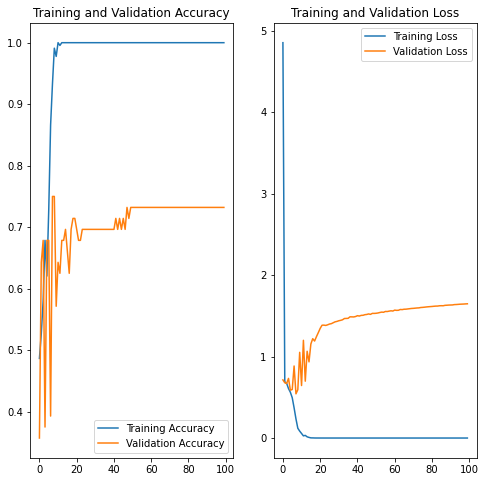

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
# Above graph indicates the sign of overfitting. Let's increase the dataset by augmentation

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal",
                                                    input_shape=(img_height,img_width,1)),
        layers.experimental.preprocessing.RandomFlip("vertical"),
#         layers.experimental.preprocessing.RandomRotation(0.1, input_shape=(img_height,img_width,1))
        layers.experimental.preprocessing.RandomRotation(0.1)
    ]
)

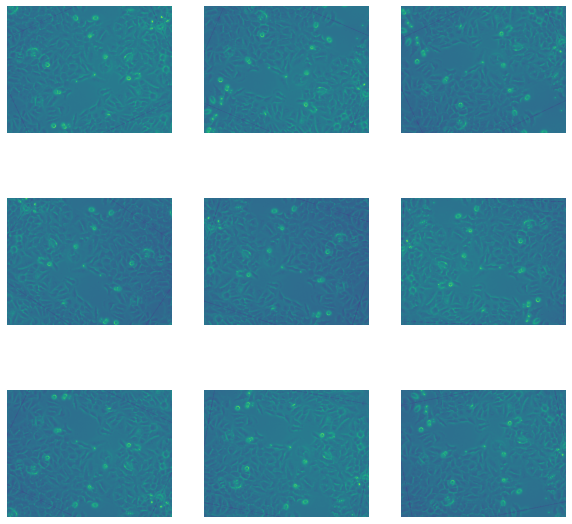

In [20]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax=plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

In [32]:
# Also, dropout technique helps reduce overfitting

# test with more filters : 32-64-128
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
#     layers.Conv2D(16, 3, padding='same', activation='relu'), # test09 conv2d 16-32-mp-64-mp-0.2-128-mp-0.2-f-256 *prediction failed
#     layers.Conv2D(32, 3, padding='same', activation='relu'), # test10 conv2d 32-32-mp-64-mp-0.2-128-mp-0.2-f-256 *prediction failed
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
#     layers.Dropout(0.2), # newly added for test07 0.2-0.2-0.2-512
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
#     layers.Dropout(0.2), # newly added for test06 0.2-0.2-512
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
#     layers.Dropout(0.3), # test16:0.4-256-lr0.0005
    layers.Flatten(),
    layers.Dropout(0.2), # test16:0.3-f-0.3-256-lr0.0005
    layers.Dense(256, activation='relu'), # or softmax #test08: 0.2.-0.2-256
    layers.Dropout(0.2), # test16:0.3-f-0.3-256-lr0.0005
#     layers.Dense(512, activation='softmax'), # softmax failed
    layers.Dense(num_classes)
    
])

# perhaps we need smaller dense layer? (ucohead used 32)

In [33]:
opt=keras.optimizers.Adam(learning_rate=0.0002) #default lr=0.001
model.compile(optimizer=opt,
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 400, 518, 1)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 400, 518, 1)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 400, 518, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 200, 259, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 200, 259, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 100, 129, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 100, 129, 128)    

In [35]:
t1_start=process_time()

epochs = 200 #test11: epoch 200 (0.2.-0.2-256) not saved / test11: 200 for (0.2-256) /test13: 200 for 0.3-256 / test14:lr0.0002
# test15: lr 0.0005 #test17: 0.2-0.2-256-lr0.0002
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

t1_stop=process_time()
print("Elapsed time: ", t1_stop, t1_start)
print("Time for total "+str(epochs) +" epochs : "+str((t1_stop-t1_start)/600) +" min.")

Epoch 1/200
7/7 [==============================] - 1s 117ms/step - loss: 1.7207 - accuracy: 0.4464 - val_loss: 0.8950 - val_accuracy: 0.3571
Epoch 2/200
7/7 [==============================] - 1s 101ms/step - loss: 0.8373 - accuracy: 0.5357 - val_loss: 0.8071 - val_accuracy: 0.3571
Epoch 3/200
7/7 [==============================] - 1s 101ms/step - loss: 0.6795 - accuracy: 0.5491 - val_loss: 0.6859 - val_accuracy: 0.6429
Epoch 4/200
7/7 [==============================] - 1s 101ms/step - loss: 0.6938 - accuracy: 0.5536 - val_loss: 0.7133 - val_accuracy: 0.3571
Epoch 5/200
7/7 [==============================] - 1s 101ms/step - loss: 0.6837 - accuracy: 0.5357 - val_loss: 0.7409 - val_accuracy: 0.3571
Epoch 6/200
7/7 [==============================] - 1s 101ms/step - loss: 0.6856 - accuracy: 0.5357 - val_loss: 0.7334 - val_accuracy: 0.3571
Epoch 7/200
7/7 [==============================] - 1s 101ms/step - loss: 0.6854 - accuracy: 0.5357 - val_loss: 0.7104 - val_accuracy: 0.3571
Epoch 8/200
7

Epoch 57/200
7/7 [==============================] - 1s 102ms/step - loss: 0.4452 - accuracy: 0.8170 - val_loss: 0.4243 - val_accuracy: 0.8214
Epoch 58/200
7/7 [==============================] - 1s 102ms/step - loss: 0.4649 - accuracy: 0.7902 - val_loss: 0.8289 - val_accuracy: 0.6071
Epoch 59/200
7/7 [==============================] - 1s 102ms/step - loss: 0.5074 - accuracy: 0.7188 - val_loss: 0.4033 - val_accuracy: 0.7857
Epoch 60/200
7/7 [==============================] - 1s 102ms/step - loss: 0.4459 - accuracy: 0.7902 - val_loss: 0.4195 - val_accuracy: 0.8036
Epoch 61/200
7/7 [==============================] - 1s 102ms/step - loss: 0.4330 - accuracy: 0.7991 - val_loss: 0.5140 - val_accuracy: 0.8036
Epoch 62/200
7/7 [==============================] - 1s 102ms/step - loss: 0.4163 - accuracy: 0.7991 - val_loss: 0.5176 - val_accuracy: 0.8036
Epoch 63/200
7/7 [==============================] - 1s 102ms/step - loss: 0.4003 - accuracy: 0.8259 - val_loss: 0.3863 - val_accuracy: 0.7679
Epoch 

7/7 [==============================] - 1s 103ms/step - loss: 0.2213 - accuracy: 0.9241 - val_loss: 0.3444 - val_accuracy: 0.8929
Epoch 115/200
7/7 [==============================] - 1s 103ms/step - loss: 0.2103 - accuracy: 0.9196 - val_loss: 0.3476 - val_accuracy: 0.8929
Epoch 116/200
7/7 [==============================] - 1s 103ms/step - loss: 0.2408 - accuracy: 0.9107 - val_loss: 0.4143 - val_accuracy: 0.8571
Epoch 117/200
7/7 [==============================] - 1s 103ms/step - loss: 0.2233 - accuracy: 0.9420 - val_loss: 0.4248 - val_accuracy: 0.8571
Epoch 118/200
7/7 [==============================] - 1s 103ms/step - loss: 0.2776 - accuracy: 0.8839 - val_loss: 0.5578 - val_accuracy: 0.8214
Epoch 119/200
7/7 [==============================] - 1s 103ms/step - loss: 0.2225 - accuracy: 0.9018 - val_loss: 0.5365 - val_accuracy: 0.7857
Epoch 120/200
7/7 [==============================] - 1s 103ms/step - loss: 0.2386 - accuracy: 0.9018 - val_loss: 0.3996 - val_accuracy: 0.8750
Epoch 121/200

7/7 [==============================] - 1s 103ms/step - loss: 0.2397 - accuracy: 0.8973 - val_loss: 0.4536 - val_accuracy: 0.8571
Epoch 172/200
7/7 [==============================] - 1s 102ms/step - loss: 0.2850 - accuracy: 0.8705 - val_loss: 0.2798 - val_accuracy: 0.8750
Epoch 173/200
7/7 [==============================] - 1s 103ms/step - loss: 0.2330 - accuracy: 0.9107 - val_loss: 0.2712 - val_accuracy: 0.9464
Epoch 174/200
7/7 [==============================] - 1s 103ms/step - loss: 0.2001 - accuracy: 0.9375 - val_loss: 0.3767 - val_accuracy: 0.8929
Epoch 175/200
7/7 [==============================] - 1s 103ms/step - loss: 0.1378 - accuracy: 0.9643 - val_loss: 0.3071 - val_accuracy: 0.9286
Epoch 176/200
7/7 [==============================] - 1s 103ms/step - loss: 0.1543 - accuracy: 0.9509 - val_loss: 0.3085 - val_accuracy: 0.9464
Epoch 177/200
7/7 [==============================] - 1s 102ms/step - loss: 0.1327 - accuracy: 0.9688 - val_loss: 0.3723 - val_accuracy: 0.9107
Epoch 178/200

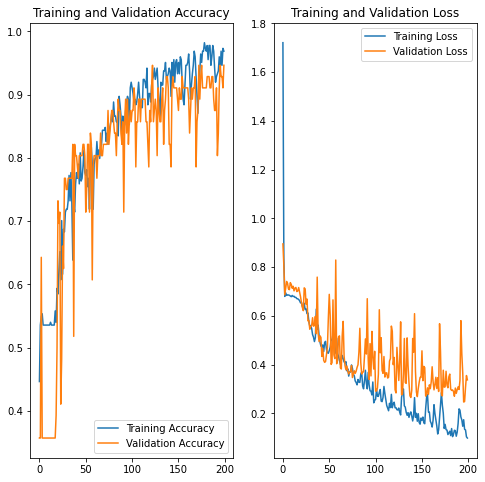

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
import pandas as pd
# df = pd.DataFrame(history)
# df.to_csv(index=False)
df = pd.DataFrame(history.history.values())
df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,1.720706,0.837287,0.679507,0.693843,0.683654,0.685573,0.685377,0.684032,0.681336,0.678446,...,0.218104,0.212583,0.184803,0.172613,0.146746,0.173524,0.134295,0.131568,0.103396,0.098379
1,0.446429,0.535714,0.549107,0.553571,0.535714,0.535714,0.535714,0.535714,0.535714,0.535714,...,0.919643,0.928571,0.933036,0.937500,0.959821,0.937500,0.968750,0.946429,0.973214,0.968750
2,0.894998,0.807089,0.685949,0.713280,0.740877,0.733365,0.710378,0.707168,0.736060,0.728806,...,0.297587,0.334693,0.580088,0.444247,0.365830,0.246157,0.248033,0.306502,0.354816,0.337068
3,0.357143,0.357143,0.642857,0.357143,0.357143,0.357143,0.357143,0.357143,0.357143,0.357143,...,0.875000,0.910714,0.803571,0.839286,0.910714,0.946429,0.928571,0.928571,0.910714,0.946429


In [39]:
df.to_csv('../test17_results.csv')

In [40]:
img = keras.preprocessing.image.load_img(
#       '../test_images/par1_early_008.jpg',
           '../test_images/par1_late_061.jpg',
#     '../test_images/wt_early_067.jpg', 
#     '../test_images/wt_late_048.jpg', 
    color_mode='grayscale', target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to par1 with a 98.71 percent confidence.
